<h1 align=center> Assignment 3 </h1>

Checkout this code on Github:

<h3>Vaibhav Sharma <br> AIML-B2 <br> 22070126125</h3>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import os

<img src="images\DCGAN Architecture.png" alt="DCGAN Generator Architecture" style="max-width: 80%; height: auto; margin: 10px auto; border: 1px solid #ddd; display: block;">
<p style="padding: 10px; border-left: 3px solid #ddd; margin-bottom: 10px;">Source: "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" by Radford et al. (2015)</p>

<p style="padding: 10px; border-left: 3px solid #ddd; margin-bottom: 10px;">Defines the <code>Generator</code> class, a neural network that generates fake images from random noise. It starts with a linear layer to project the latent vector (size 100) to a 4x4x512 feature map, reshapes it, and uses four transposed convolutional layers to upsample it to a 64x64x3 RGB image. Batch normalization and ReLU activations stabilize training, with a final Tanh activation scaling outputs to [-1, 1].</p>

In [2]:
# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim  # Latent space dimension (input noise size)

        self.main = nn.Sequential(
            # Fully connected layer to project the latent vector to a 4x4x512 feature map
            nn.Linear(latent_dim, 4 * 4 * 512, bias=False),
            nn.BatchNorm1d(4 * 4 * 512),  # Normalize batch to stabilize training
            nn.ReLU(),  # Activation function
            # Reshape the linear output into (512, 4, 4) tensor
            nn.Unflatten(1, (512, 4, 4)),
            # First transposed convolution to upsample from 4x4 to 8x8
            nn.ConvTranspose2d(
                512,
                256,
                kernel_size=5,
                stride=2,
                padding=2,
                output_padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(256),  # Batch normalization to stabilize training
            nn.ReLU(),
            # Second transposed convolution to upsample from 8x8 to 16x16
            nn.ConvTranspose2d(
                256,
                128,
                kernel_size=5,
                stride=2,
                padding=2,
                output_padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Third transposed convolution to upsample from 16x16 to 32x32
            nn.ConvTranspose2d(
                128,
                64,
                kernel_size=5,
                stride=2,
                padding=2,
                output_padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # Final transposed convolution to output a 3-channel image (RGB) of size 64x64
            nn.ConvTranspose2d(
                64, 3, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False
            ),
            nn.Tanh(),  # Tanh activation to scale pixel values between -1 and 1
        )

    def forward(self, x):
        return self.main(x)  # Forward pass through the network

<p style="padding: 10px; border-left: 3px solid #ddd; margin-bottom: 10px;">Defines the <code>Discriminator</code> class, a neural network that classifies images as real or fake. It uses four convolutional layers to downsample a 64x64x3 image to a 4x4x512 feature map, with batch normalization and LeakyReLU (slope 0.2) for stability. The output is flattened and passed through a linear layer with a sigmoid activation to produce a probability between 0 and 1.</p>

In [3]:
# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # First convolutional layer: 64 filters, downsampling from 64x64 to 32x32
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(
                0.2
            ),  # LeakyReLU to allow small gradient flow for negative values
            # Second convolutional layer: 128 filters, downsampling from 32x32 to 16x16
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # Third convolutional layer: 256 filters, downsampling from 16x16 to 8x8
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # Fourth convolutional layer: 512 filters, downsampling from 8x8 to 4x4
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # Flatten the feature map (512 * 4 * 4) into a single vector
            nn.Flatten(),
            # Fully connected layer to output a single probability value (real or fake)
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid(),  # Sigmoid activation to constrain output between 0 and 1
        )

    def forward(self, x):
        return self.main(x)  # Forward pass through the network

<p style="padding: 10px; border-left: 3px solid #ddd; margin-bottom: 10px;">Sets hyperparameters: <code>latent_dim=100</code> for the noise input size, <code>batch_size=16</code> for training batches, learning rates <code>gen_lr=2e-4</code> and <code>disc_lr=2e-4</code> for the Generator and Discriminator, <code>n_gen_updates=4</code> for Generator updates per Discriminator update, and <code>total_epochs=20</code> for the training duration.</p>

In [4]:
# Hyperparameters
latent_dim = 100  # Size of the latent vector (random noise input for Generator)
batch_size = 16  # Number of images per training batch
gen_lr = 2e-4  # Learning rate for the Generator
disc_lr = 2e-4  # Learning rate for the Discriminator
n_gen_updates = 4  # Number of times to update Generator per Discriminator update
total_epochs = 20  # Total number of training epochs

<p style="padding: 10px; border-left: 3px solid #ddd; margin-bottom: 10px;">Determines the computation device (<code>cuda</code> if GPU is available, else <code>cpu</code>) and prints it, ensuring the model runs on the appropriate hardware.</p>

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<p style="padding: 10px; border-left: 3px solid #ddd; margin-bottom: 10px;">Prepares the dataset and DataLoader. Applies transformations to resize images to 64x64, convert them to tensors, and normalize them to [-1, 1]. Loads the CelebA dataset from the 'celeba' folder and creates a DataLoader with batch size 16, shuffling, and 4 worker threads for efficient data loading.</p>

In [ ]:
# Dataset and DataLoader
transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),  # Resize images to 64x64 resolution
        transforms.ToTensor(),  # Convert images to tensor format
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
    ]
)

dataset = datasets.ImageFolder(root="data", transform=transform)

# Create DataLoader for efficient mini-batch training
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

<p style="padding: 10px; border-left: 3px solid #ddd; margin-bottom: 10px;">Initializes the <code>Generator</code> and <code>Discriminator</code> models, moves them to the selected device, and defines the loss function as Binary Cross Entropy (<code>BCELoss</code>), commonly used for GAN training to compare predicted probabilities with real/fake labels.</p>

In [ ]:
# Initialize Generator and Discriminator models
generator = Generator(latent_dim).to(
    device
)  # Move Generator to the selected device (GPU/CPU)
discriminator = Discriminator().to(device)  # Move Discriminator to the selected device
# Loss function (Binary Cross Entropy Loss for GANs)
criterion = nn.BCELoss()

<p style="padding: 10px; border-left: 3px solid #ddd; margin-bottom: 10px;">Sets up Adam optimizers for both the Generator and Discriminator with their respective learning rates (<code>gen_lr</code>, <code>disc_lr</code>) and beta values (0.5, 0.999) for better convergence in GAN training.</p>

In [ ]:
# Optimizers
generator_optimizer = optim.Adam(
    generator.parameters(),
    lr=gen_lr,
    betas=(0.5, 0.999),  # Adam optimizer for Generator
)
discriminator_optimizer = optim.Adam(
    discriminator.parameters(),
    lr=disc_lr,
    betas=(0.5, 0.999),  # Adam optimizer for Discriminator
)

<p style="padding: 10px; border-left: 3px solid #ddd; margin-bottom: 10px;">Creates directories 'checkpoints' and 'images' if they don’t exist, using <code>os.makedirs</code> with <code>exist_ok=True</code>, to store model checkpoints and generated images during training.</p>

In [ ]:
os.makedirs("checkpoints", exist_ok=True) # Initialize Directory for storing checkpoints
os.makedirs("images", exist_ok=True) # Initialize Directory for storing images

<p style="padding: 10px; border-left: 3px solid #ddd; margin-bottom: 10px;">Initializes empty lists <code>gen_losses</code> and <code>disc_losses</code> to store the average Generator and Discriminator losses for each epoch, useful for later analysis and plotting.</p>

In [ ]:
gen_losses = [] # for storing generator losses
disc_losses = [] # for storing discriminator losses

<p style="padding: 10px; border-left: 3px solid #ddd; margin-bottom: 10px;">Implements the GAN training loop over <code>total_epochs</code>. For each epoch, it iterates over batches of real images, trains the Discriminator on real and fake images, then updates the Generator <code>n_gen_updates</code> times. Losses are tracked, models are saved after each epoch, and progress is displayed with <code>tqdm</code>. Finally, losses are saved to 'losses.csv'.</p>

In [ ]:
# Training Loop
for epoch in range(total_epochs):
    epoch_gen_loss = 0.0  # Cumulative Generator loss for the epoch
    epoch_disc_loss = 0.0  # Cumulative Discriminator loss for the epoch
    num_batches = 0  # Counter for number of batches

    # Create a progress bar for tracking training per epoch
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{total_epochs}", leave=True)

    for real_images, _ in progress_bar:
        real_images = real_images.to(
            device
        )  # Move real images to the selected device (CPU/GPU)
        current_batch_size = real_images.size(
            0
        )  # Get batch size (can be smaller for last batch)

        # Generate random noise for Generator input
        noise = torch.randn(current_batch_size, latent_dim, device=device)

        ### Train Discriminator ###
        with torch.no_grad():
            fake_images = generator(
                noise
            )  # Generate fake images (detached to avoid Generator update)

        real_output = discriminator(
            real_images
        )  # Discriminator's prediction on real images
        fake_output = discriminator(
            fake_images
        )  # Discriminator's prediction on fake images

        # Compute Discriminator loss
        disc_loss_real = criterion(
            real_output, torch.ones_like(real_output)
        )  # Real images → label 1
        disc_loss_fake = criterion(
            fake_output, torch.zeros_like(fake_output)
        )  # Fake images → label 0
        disc_loss = disc_loss_real + disc_loss_fake  # Total Discriminator loss

        # Backpropagation for Discriminator
        discriminator_optimizer.zero_grad()
        disc_loss.backward()
        discriminator_optimizer.step()

        ### Train Generator ###
        gen_loss_total = 0.0  # Accumulate Generator loss over multiple updates
        for _ in range(
            n_gen_updates
        ):  # Generator is updated multiple times per Discriminator update
            fake_images = generator(noise)  # Generate fake images
            fake_output = discriminator(fake_images)  # Discriminator evaluates them

            # Compute Generator loss (wants fake images to be classified as real)
            gen_loss = criterion(fake_output, torch.ones_like(fake_output))

            # Backpropagation for Generator
            generator_optimizer.zero_grad()
            gen_loss.backward()
            generator_optimizer.step()

            gen_loss_total += gen_loss.item()  # Accumulate Generator loss

        # Compute average Generator loss for this batch
        avg_gen_loss_batch = gen_loss_total / n_gen_updates

        # Update epoch-level loss tracking
        epoch_gen_loss += avg_gen_loss_batch
        epoch_disc_loss += disc_loss.item()
        num_batches += 1

        # Update progress bar with current batch loss
        progress_bar.set_postfix(
            {
                "Gen Loss": f"{gen_loss.item():.4f}",
                "Disc Loss": f"{disc_loss.item():.4f}",
            }
        )

    # Compute average loss per epoch
    avg_gen_loss = epoch_gen_loss / num_batches
    avg_disc_loss = epoch_disc_loss / num_batches
    gen_losses.append(avg_gen_loss)
    disc_losses.append(avg_disc_loss)

    # Print epoch loss summary
    print(
        f"Epoch {epoch+1}/{total_epochs} - Avg Gen Loss: {avg_gen_loss:.4f}, Avg Disc Loss: {avg_disc_loss:.4f}"
    )

    # Save Generator and Discriminator models after each epoch
    torch.save(generator.state_dict(), f"checkpoints/generator_epoch_{epoch+1}.pth")
    torch.save(
        discriminator.state_dict(), f"checkpoints/discriminator_epoch_{epoch+1}.pth"
    )

# Save training loss history to a CSV file for analysis
loss_df = pd.DataFrame(
    {
        "Epoch": list(range(1, total_epochs + 1)),
        "Gen Loss": gen_losses,
        "Disc Loss": disc_losses,
    }
)
loss_df.to_csv("losses.csv", index=False)

print("Training completed!")  # Indicate that training has finished

Epoch 1/20: 100%|██████████| 12663/12663 [19:43<00:00, 10.70it/s, Gen Loss=0.0571, Disc Loss=1.0112]


Epoch 1/20 - Avg Gen Loss: 0.7386, Avg Disc Loss: 1.3699


Epoch 2/20: 100%|██████████| 12663/12663 [19:39<00:00, 10.74it/s, Gen Loss=0.0220, Disc Loss=0.7818]


Epoch 2/20 - Avg Gen Loss: 1.2674, Avg Disc Loss: 0.6200


Epoch 3/20: 100%|██████████| 12663/12663 [19:10<00:00, 11.01it/s, Gen Loss=0.0079, Disc Loss=0.1253]


Epoch 3/20 - Avg Gen Loss: 1.5251, Avg Disc Loss: 0.4233


Epoch 4/20: 100%|██████████| 12663/12663 [18:05<00:00, 11.66it/s, Gen Loss=0.0065, Disc Loss=0.2079]


Epoch 4/20 - Avg Gen Loss: 1.7560, Avg Disc Loss: 0.3315


Epoch 5/20: 100%|██████████| 12663/12663 [20:06<00:00, 10.49it/s, Gen Loss=0.0023, Disc Loss=0.3056]


Epoch 5/20 - Avg Gen Loss: 1.9372, Avg Disc Loss: 0.2794


Epoch 6/20: 100%|██████████| 12663/12663 [23:19<00:00,  9.05it/s, Gen Loss=0.0144, Disc Loss=0.6253]


Epoch 6/20 - Avg Gen Loss: 2.0863, Avg Disc Loss: 0.2543


Epoch 7/20: 100%|██████████| 12663/12663 [18:55<00:00, 11.15it/s, Gen Loss=0.0080, Disc Loss=0.1183]


Epoch 7/20 - Avg Gen Loss: 2.2319, Avg Disc Loss: 0.2348


Epoch 8/20: 100%|██████████| 12663/12663 [18:07<00:00, 11.65it/s, Gen Loss=0.0036, Disc Loss=0.0932]


Epoch 8/20 - Avg Gen Loss: 2.3784, Avg Disc Loss: 0.2275


Epoch 9/20: 100%|██████████| 12663/12663 [17:59<00:00, 11.73it/s, Gen Loss=0.2734, Disc Loss=0.6224]


Epoch 9/20 - Avg Gen Loss: 2.4768, Avg Disc Loss: 0.2268


Epoch 10/20: 100%|██████████| 12663/12663 [18:00<00:00, 11.72it/s, Gen Loss=0.0086, Disc Loss=0.0282]


Epoch 10/20 - Avg Gen Loss: 2.5981, Avg Disc Loss: 0.2221


Epoch 11/20: 100%|██████████| 12663/12663 [18:14<00:00, 11.57it/s, Gen Loss=0.0066, Disc Loss=0.0082]


Epoch 11/20 - Avg Gen Loss: 2.6466, Avg Disc Loss: 0.2139


Epoch 12/20: 100%|██████████| 12663/12663 [18:00<00:00, 11.72it/s, Gen Loss=0.0103, Disc Loss=0.4301]


Epoch 12/20 - Avg Gen Loss: 2.7248, Avg Disc Loss: 0.2048


Epoch 13/20: 100%|██████████| 12663/12663 [18:04<00:00, 11.68it/s, Gen Loss=0.0088, Disc Loss=0.0651] 


Epoch 13/20 - Avg Gen Loss: 2.8061, Avg Disc Loss: 0.2016


Epoch 14/20: 100%|██████████| 12663/12663 [17:57<00:00, 11.75it/s, Gen Loss=0.0356, Disc Loss=1.3707] 


Epoch 14/20 - Avg Gen Loss: 2.8919, Avg Disc Loss: 0.1956


Epoch 15/20: 100%|██████████| 12663/12663 [17:59<00:00, 11.73it/s, Gen Loss=0.8546, Disc Loss=0.7287] 


Epoch 15/20 - Avg Gen Loss: 2.9837, Avg Disc Loss: 0.1819


Epoch 16/20: 100%|██████████| 12663/12663 [18:03<00:00, 11.69it/s, Gen Loss=0.0276, Disc Loss=0.2977] 


Epoch 16/20 - Avg Gen Loss: 3.0968, Avg Disc Loss: 0.1807


Epoch 17/20: 100%|██████████| 12663/12663 [18:02<00:00, 11.70it/s, Gen Loss=0.0300, Disc Loss=0.0145]


Epoch 17/20 - Avg Gen Loss: 3.1309, Avg Disc Loss: 0.1677


Epoch 18/20: 100%|██████████| 12663/12663 [18:00<00:00, 11.72it/s, Gen Loss=0.0102, Disc Loss=0.0001] 


Epoch 18/20 - Avg Gen Loss: 3.2736, Avg Disc Loss: 0.1629


Epoch 19/20: 100%|██████████| 12663/12663 [17:59<00:00, 11.73it/s, Gen Loss=0.0046, Disc Loss=0.3972] 


Epoch 19/20 - Avg Gen Loss: 3.2861, Avg Disc Loss: 0.1612


Epoch 20/20: 100%|██████████| 12663/12663 [18:02<00:00, 11.70it/s, Gen Loss=0.0615, Disc Loss=0.4434] 

Epoch 20/20 - Avg Gen Loss: 3.3492, Avg Disc Loss: 0.1531
Training completed!


<p style="padding: 10px; border-left: 3px solid #ddd; margin-bottom: 10px;">Loads the training losses from 'losses.csv', plots them using <code>matplotlib</code> with Generator loss (circles) and Discriminator loss (squares) over epochs, adds labels and a grid, saves the plot as 'loss_plot.png', and displays it to visualize training progress.</p>

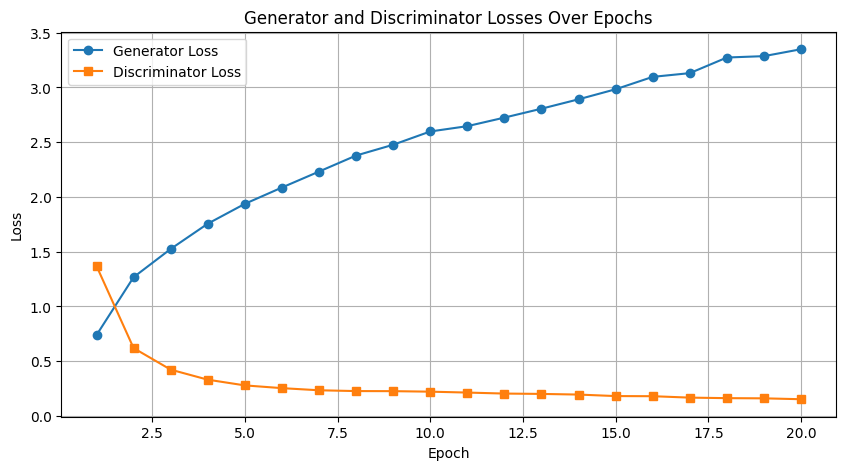

In [14]:
loss_df = pd.read_csv("losses.csv")
plt.figure(figsize=(10, 5))
plt.plot(loss_df["Epoch"], loss_df["Gen Loss"], label="Generator Loss", marker="o")
plt.plot(loss_df["Epoch"], loss_df["Disc Loss"], label="Discriminator Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.savefig("images/loss_plot.png")
plt.show()

<h1 align=center> Model Testing </h1>

<p style="padding: 10px; border-left: 3px solid #ddd; margin-bottom: 10px;">Initializes the Generator and Discriminator models with <code>latent_dim=100</code> and moves them to the selected device (CPU/GPU). It loads the pre-trained Generator weights from <code>checkpoints/generator_epoch_20.pth</code> using <code>torch.load</code> with <code>map_location=device</code> for device compatibility, sets the Generator to evaluation mode with <code>.eval()</code>, generates 5 random noise vectors with <code>torch.randn</code>, and uses the Generator to create fake images, which are then moved to the CPU and denormalized from [-1, 1] to [0, 1] for plotting.</p>

In [6]:
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

generator.load_state_dict(
    torch.load("checkpoints/generator_epoch_20.pth", map_location=device)
)
generator.eval()

num_samples = 5
noise = torch.randn(num_samples, latent_dim, device=device)

with torch.no_grad():
    fake_images = generator(noise).cpu()

fake_images = (fake_images + 1) / 2

<p style="padding: 10px; border-left: 3px solid #ddd; margin-bottom: 10px;">Creates a figure with <code>plt.figure(figsize=(15, 3))</code> to display the 5 generated images in a single row. A loop iterates over <code>num_samples</code>, using <code>plt.subplot</code> to place each image, <code>plt.imshow</code> with <code>permute(1, 2, 0)</code> to convert from CHW to HWC format for display, and adds a title like 'Generated 1'. Axes are turned off with <code>plt.axis('off')</code>, a suptitle is set with <code>plt.suptitle</code>, layout is adjusted with <code>plt.tight_layout</code>, the plot is saved as 'generated_images.png' with 300 DPI, and finally displayed with <code>plt.show()</code>.</p>

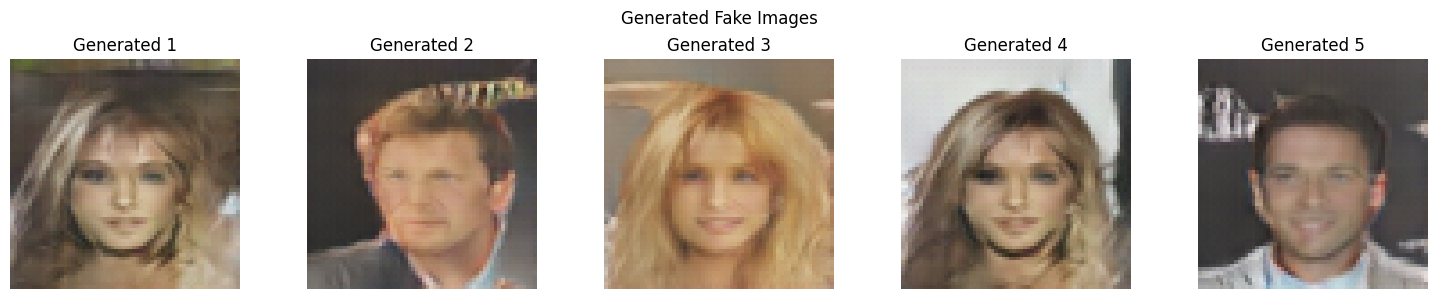

In [7]:
plt.figure(figsize=(15, 3))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(fake_images[i].permute(1, 2, 0))
    plt.title(f"Generated {i+1}")
    plt.axis("off")

plt.suptitle("Generated Fake Images")
plt.tight_layout()
plt.savefig("images/generated_images.png", dpi=300)
plt.show()